In [1]:
import os
import math
import random
import argparse
from collections import Counter, defaultdict
from itertools import chain, combinations
import ast
import copy
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression

### Local Imports

In [2]:
from utils.Spambase.split_data import split_data_equal
from utils.aggregate_functions import aggregate_lr_models
from utils.evaluate_coalitions import evaluate_coalitions
from utils.Nash import find_nash_equilibria_v2
from utils.shapley_value import compute_and_visualize_shapley_values

# HuGaDB Dataset

In [3]:
train_files_pattern = "/Users/abbaszal/Documents/Thesis_Project_Spambase/data/metadata/train_{i:02d}.csv" # Adjust the path as needed
test_files_pattern = "/Users/abbaszal/Documents/Thesis_Project_Spambase/data/metadata/test_{i:02d}.csv" # Adjust the path as needed

### Creating Global Train set and Test set and Preprocessing

In [4]:
# Load training and testing datasets
df_train_global = pd.concat([pd.read_csv(train_files_pattern.format(i=i)) for i in range(1, 11)]).dropna()
X_train_global = df_train_global.drop('act', axis=1)
y_train_global = df_train_global['act']

df_test_global = pd.concat([pd.read_csv(test_files_pattern.format(i=i)) for i in range(1, 11)]).dropna()
X_test_global = df_test_global.drop('act', axis=1)
y_test_global = df_test_global['act']

# Encode labels
label_encoder = LabelEncoder()
y_train_global = label_encoder.fit_transform(y_train_global)
y_test_global = label_encoder.transform(y_test_global)

# Scale features
scaler = StandardScaler()
X_train_global_scaled = scaler.fit_transform(X_train_global)
X_test_global_scaled = scaler.transform(X_test_global)


In [5]:
# disable ConvergenceWarnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

#### Centrelized Training


Confusion Matrix for Trial 1:
[[ 3073  2298     5    72  1533   146  5394]
 [ 1340  3709     6   226  1781   264  5430]
 [    0     0  7595     0     0     0     0]
 [   11    59   318  1165    46     0   337]
 [   69     8     6     4 22422    11  4150]
 [    2   119   376     0   395  1331   139]
 [ 1671  2174    12   158  6070   135 28241]]


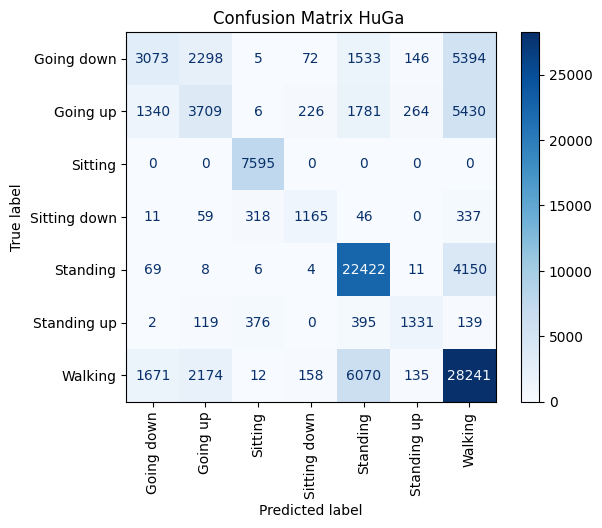

Trial 1 - Global test accuracy: 0.660169499809386


In [22]:
# Parameters
trial = 1
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)

results_global = []

# Initialize Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=100)  
model.fit(X_train_global_scaled, y_train_global)  

# Predict on the test set
y_pred = model.predict(X_test_global_scaled)
acc_test = accuracy_score(y_test_global, y_pred)  # Compute test accuracy

# Confusion matrix
cm = confusion_matrix(y_test_global, y_pred)
print(f"\nConfusion Matrix for Trial {trial }:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title(f"Confusion Matrix HuGa ")
plt.show()

results_global.append(acc_test)

print(f"Trial {trial} - Global test accuracy: {acc_test}")

## Federated Learning (FedLR) _ without low-quality clients _ HuGaDB

In [23]:
# Parameters
n_clients = 10
n_trials = 1
random_seed = 42

results = []

for trial in range(n_trials):
    print(f"Trial {trial + 1}/{n_trials}")

    client_models = []
    client_global_accuracies = []

    for i in range(n_clients):
        # Load client-specific training data
        df_train_i = pd.read_csv(train_files_pattern.format(i=i+1)).dropna(subset=['act'])
        X_train = df_train_i.drop('act', axis=1)
        y_train = label_encoder.transform(df_train_i['act'])

        # Train a Logistic Regression model for the client
        model = LogisticRegression(random_state=random_seed + trial, max_iter=100)
        model.fit(scaler.fit_transform(X_train), y_train)
        client_models.append(model)

        # Evaluate model on the global test set
        y_pred_global = model.predict(X_test_global_scaled)
        acc_global = accuracy_score(y_test_global, y_pred_global)
        client_global_accuracies.append(acc_global)

    # Evaluate all coalitions using the helper function
    df_trial_results = evaluate_coalitions(
        client_models=client_models,
        client_global_accuracies=client_global_accuracies,
        n_clients=n_clients,
        aggregator_func=aggregate_lr_models,
        X_test=X_test_global_scaled,
        y_test=y_test_global,
        corrupt_client_indices=[], 
        approach='fedlr'
    )
    df_trial_results['Trial'] = trial + 1
    results.append(df_trial_results)

# Combine and save
df_results = pd.concat(results, ignore_index=True)


save_dir = "/Users/abbaszal/Documents/Thesis_Project_Spambase/results/HuGaDB_without_LQC"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "HuGaDB_results_with_LR.csv")
df_results.to_csv(save_path, index=False)


Trial 1/1


In [24]:
df_results.sort_values(by=['Global Accuracy'], ascending=False).head(5)

,Combination,Clients,Global Accuracy,Client 1 Accuracy,Client 2 Accuracy,Client 3 Accuracy,Client 4 Accuracy,Client 5 Accuracy,Client 6 Accuracy,Client 7 Accuracy,Client 8 Accuracy,Client 9 Accuracy,Client 10 Accuracy,Trial
92,0001011101,"[1, 3, 4, 5, 7]",0.655477,0.462439,0.4172,0.602545,0.605585,0.610874,0.573347,0.611802,0.592321,0.580385,0.556466,1
220,0011011101,"[1, 3, 4, 5, 7, 8]",0.654911,0.462439,0.4172,0.602545,0.605585,0.610874,0.573347,0.611802,0.592321,0.580385,0.556466,1
204,0011001101,"[1, 3, 4, 7, 8]",0.654686,0.462439,0.4172,0.602545,0.605585,0.610874,0.573347,0.611802,0.592321,0.580385,0.556466,1
460,0111001101,"[1, 3, 4, 7, 8, 9]",0.654001,0.462439,0.4172,0.602545,0.605585,0.610874,0.573347,0.611802,0.592321,0.580385,0.556466,1
252,0011111101,"[1, 3, 4, 5, 6, 7, 8]",0.653943,0.462439,0.4172,0.602545,0.605585,0.610874,0.573347,0.611802,0.592321,0.580385,0.556466,1


In [25]:
nash_df = find_nash_equilibria_v2(df_results)
nash_df

,Combination,Clients,Global Accuracy,Trial
0,0000000011,"[1, 2]",0.470846,1
1,1111111111,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",0.646054,1


      Client  Local Accuracy  Normalized Shapley Value
6   Client 7        0.611802                  0.124284
4   Client 5        0.610874                  0.118965
3   Client 4        0.605585                  0.114509
2   Client 3        0.602545                  0.114051
8   Client 9        0.580385                  0.111773
7   Client 8        0.592321                  0.109854
5   Client 6        0.573347                  0.103525
9  Client 10        0.556466                  0.102551
0   Client 1        0.462439                  0.071452
1   Client 2        0.417200                  0.029037


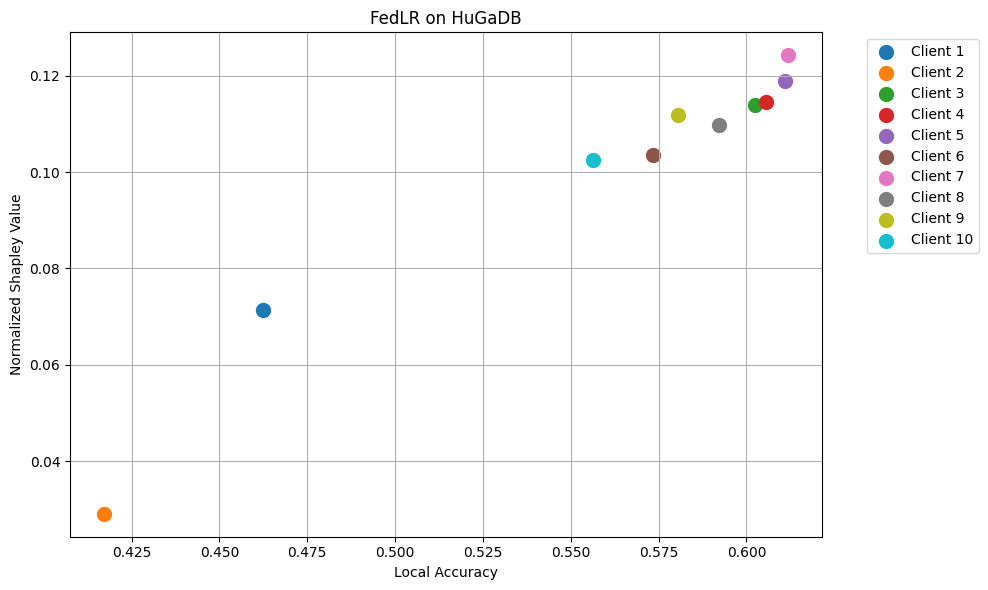

In [26]:
result = compute_and_visualize_shapley_values(
    df_results, 
    client_local_accuracies={i: client_global_accuracies[i] for i in range(n_clients)}, 
    n_clients=10,  
    plot=True,  
    model_name="FedLR on HuGaDB",  
    print_df=True 
)


#### Evaluating Grand coalition as a Nash Eq For HuGaDB in 350 number of samples for each client and different Max_iter Without LQC

In [6]:
# File patterns.
train_files_pattern = "/Users/abbaszal/Documents/Thesis_Project_Spambase/data/metadata/train_{i:02d}.csv"
test_files_pattern = "/Users/abbaszal/Documents/Thesis_Project_Spambase/data/metadata/test_{i:02d}.csv"

# Concatenate all training files.
df_train_global = pd.concat([
    pd.read_csv(train_files_pattern.format(i=i)) for i in range(1, 11)
]).dropna()

# Concatenate all testing files.
df_test_global = pd.concat([
    pd.read_csv(test_files_pattern.format(i=i)) for i in range(1, 11)
]).dropna()

# Split features and labels.
X_train_global = df_train_global.drop('act', axis=1)
y_train_global = df_train_global['act']

X_test_global = df_test_global.drop('act', axis=1)
y_test_global = df_test_global['act']

# Encode labels.
label_encoder = LabelEncoder()
y_train_global = label_encoder.fit_transform(y_train_global)
y_test_global = label_encoder.transform(y_test_global)

# Scale features.
scaler_global = StandardScaler()
X_train_global_scaled = scaler_global.fit_transform(X_train_global)
X_test_global_scaled  = scaler_global.transform(X_test_global)
# Create a stratified subsample of the test set to speed up the runtime.
subsample_size = 950  
X_test_global_scaled, _, y_test_global, _ = train_test_split(
    X_test_global_scaled, y_test_global,
    train_size=subsample_size,
    random_state=42,
    stratify=y_test_global
)
print("Subsampled test set shape:", X_test_global_scaled.shape)

Subsampled test set shape: (950, 38)


In [ ]:
# Parameters
n_clients = 10
n_trials = 50
base_random_seed = 42
max_iters = [10, 100]
sample_size = 350
approach = 'fedlr'

# Saving directory
save_dir = "/Users/abbaszal/Documents/Thesis_Project_Spambase/results/HuGaDB_without_LQC/evaluate_grand_combination_without_LQC"
os.makedirs(save_dir, exist_ok=True)

train_files_pattern = "/Users/abbaszal/Documents/Thesis_Project_Spambase/data/metadata/train_{i:02d}.csv"
test_files_pattern = "/Users/abbaszal/Documents/Thesis_Project_Spambase/data/metadata/test_{i:02d}.csv"

all_details = []


for max_iter in max_iters:
    print(f"\nRunning experiment: max_iter={max_iter}")
    nash_counts = Counter()
    details_for_this_param = []
    client_accuracy_details = []

    for trial in range(n_trials):

        rand_component = random.randint(0, 500)
        trial_seed = base_random_seed + trial + int(1000 * max_iter) + 2 * rand_component
        random.seed(trial_seed)
        np.random.seed(trial_seed)

        # --- Train each client with fixed sample size ---
        client_models = []
        client_global_accuracies = {}

        for client_idx in range(n_clients):
            df_train_local = pd.read_csv(train_files_pattern.format(i=client_idx + 1)).dropna(subset=['act'])

            
            df_train_local, _ = train_test_split(
                df_train_local,
                train_size=sample_size,
                random_state=trial_seed,
                stratify=df_train_local['act']
            )


            df_train_local = df_train_local.reset_index(drop=True).dropna()
            y_train_local = label_encoder.transform(df_train_local['act'])
            X_train_local = df_train_local.drop('act', axis=1).values
            X_train_local_scaled = scaler.transform(X_train_local)


            model = LogisticRegression(random_state=trial_seed, max_iter=max_iter)
            model.fit(X_train_local_scaled, y_train_local)
            client_models.append(model)

            y_pred_global = model.predict(X_test_global_scaled)
            acc_global = accuracy_score(y_test_global, y_pred_global)
            client_global_accuracies[client_idx] = acc_global

        # --- Evaluate all model coalitions ---
        df_results = evaluate_coalitions(
            client_models=client_models,
            client_global_accuracies=client_global_accuracies,
            n_clients=n_clients,
            aggregator_func=aggregate_lr_models,
            X_test=X_test_global_scaled,
            y_test=y_test_global,
            corrupt_client_indices=[],
            approach=approach
        )
        df_results['Trial'] = trial + 1
        df_results['Max Iter or Depth'] = max_iter

        # --- Find Nash Equilibria ---
        df_nash = find_nash_equilibria_v2(df_results.reset_index())
        for coalition in df_nash['Combination']:
            nash_counts[coalition] += 1

        df_nash['Trial'] = trial + 1
        df_nash['Max Iter or Depth'] = max_iter
        details_for_this_param.append(df_nash)

        # --- Client Accuracies ---
        trial_acc = {
            'Trial': trial + 1,
            'Max Iter or Depth': max_iter
        }
        for j in range(n_clients):
            trial_acc[f'Client {j+1} Accuracy'] = client_global_accuracies.get(j, np.nan)
        client_accuracy_details.append(trial_acc)

    # --- Save Nash count summary ---
    df_nash_counts = pd.DataFrame(nash_counts.items(), columns=['Nash Equilibrium', 'Occurrences'])
    df_nash_counts['Max Iter or Depth'] = max_iter
    filename_counts = os.path.join(save_dir, f"Nash_Equilibrium_Counts_{approach}_maxiter_{max_iter}.csv")
    df_nash_counts.to_csv(filename_counts, index=False)

    # --- Merge and save trial details ---
    df_details = pd.concat(details_for_this_param, ignore_index=True)
    df_client_accuracy = pd.DataFrame(client_accuracy_details)
    df_combined = df_details.merge(
        df_client_accuracy,
        on=['Trial', 'Max Iter or Depth'],
        how='left'
    )
    all_details.append(df_combined)

# --- Save full merged results ---
final_details_df = pd.concat(all_details, ignore_index=True)
details_path = os.path.join(save_dir, f"Nash_Equilibrium_Details_{approach}.csv")
final_details_df.to_csv(details_path, index=False)


# Spambase Dataset

In [27]:
file_path = '/Users/abbaszal/Documents/Thesis_Project_Spambase/data/spambase.data'  # Adjust the path as needed
df = pd.read_csv(file_path, header=None)

### Creating Global Train set and Test set and Preprocessing

In [28]:
random_seed= 42
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Centrelized Training

Accuracy: 0.9197


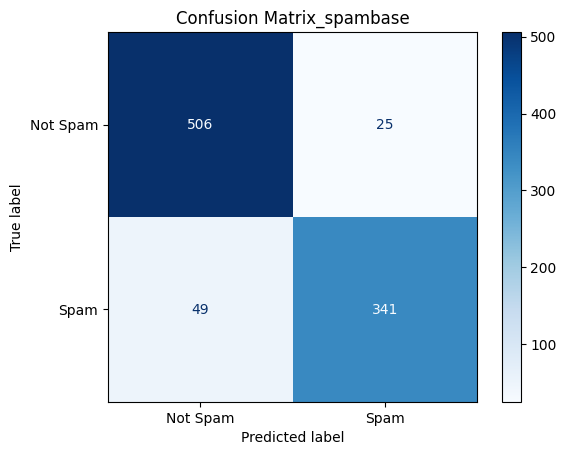

In [29]:
# Train the Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=100)  
model.fit(X_train, y_train)

# Evaluate the model
acc = model.score(X_test, y_test)  
print(f"Accuracy: {acc:.4f}")


y_pred = model.predict(X_test)


cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Spam", "Spam"])
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix_spambase")
plt.show()

## Federated Learning (FedLR) _ without low-quality clients _ Spambase

In [30]:
# Split data among clients
partitions = split_data_equal(X_train, y_train, n_clients=10, shuffle=True)

In [ ]:
def train_models_fedlr(partitions, random_seed, X_test, y_test, max_iter):
    client_models = []
    client_global_accuracies = []
    
    for X_i, y_i in partitions:
        # Clean data: remove rows with NaN values.
        nan_mask = ~np.isnan(X_i).any(axis=1)
        X_clean = X_i[nan_mask]
        y_clean = y_i[nan_mask]
        if len(y_clean) == 0:
            client_models.append(None)
            client_global_accuracies.append(None)
            continue
        
        model = LogisticRegression(random_state=random_seed, max_iter=max_iter)
        try:
            local_scaler = StandardScaler()
            model.fit(local_scaler.fit_transform(X_clean), y_clean)
            client_models.append(model)
            client_global_accuracies.append(model.score(X_test, y_test))
        except Exception as e:
            client_models.append(None)
            client_global_accuracies.append(None)
    
    return client_models, client_global_accuracies

In [42]:
# Parameters
n_clients = 10
n_trials = 1
random_seed = 42
max_iter = 100

results = []

for trial in range(n_trials):
    print(f"Trial {trial + 1}/{n_trials}")

    # Train client models
    client_models, client_global_accuracies = train_models_fedlr(
        partitions, random_seed, X_test, y_test, max_iter
    )

    # Evaluate all coalitions using the helper function
    df_trial_results = evaluate_coalitions(
        client_models=client_models,
        client_global_accuracies=client_global_accuracies,
        n_clients=n_clients,
        aggregator_func=aggregate_lr_models,
        X_test=X_test,
        y_test=y_test,
        corrupt_client_indices=[],  
        approach='fedlr'
    )
    df_trial_results['Trial'] = trial + 1
    results.append(df_trial_results)

# Combine results
df_results = pd.concat(results, ignore_index=True)

# Create save directory
save_dir = "/Users/abbaszal/Documents/Thesis_Project_Spambase/results/Spambase_without_LQC"
os.makedirs(save_dir, exist_ok=True)

# Save CSV
save_path = os.path.join(save_dir, "Spambase_results_with_LR.csv")
df_results.to_csv(save_path, index=False)

Trial 1/1


In [43]:
top_results = df_results.sort_values(by=['Global Accuracy'], ascending=False).head(5)
top_results

,Combination,Clients,Global Accuracy,Client 1 Accuracy,Client 2 Accuracy,Client 3 Accuracy,Client 4 Accuracy,Client 5 Accuracy,Client 6 Accuracy,Client 7 Accuracy,Client 8 Accuracy,Client 9 Accuracy,Client 10 Accuracy,Trial
983,1111011000,"[4, 5, 7, 8, 9, 10]",0.937025,0.877307,0.893594,0.875136,0.89468,0.907709,0.907709,0.917481,0.884908,0.884908,0.889251,1
999,1111101000,"[4, 6, 7, 8, 9, 10]",0.934853,0.877307,0.893594,0.875136,0.89468,0.907709,0.907709,0.917481,0.884908,0.884908,0.889251,1
855,1101011000,"[4, 5, 7, 9, 10]",0.933768,0.877307,0.893594,0.875136,0.89468,0.907709,0.907709,0.917481,0.884908,0.884908,0.889251,1
891,1101111100,"[3, 4, 5, 6, 7, 9, 10]",0.933768,0.877307,0.893594,0.875136,0.89468,0.907709,0.907709,0.917481,0.884908,0.884908,0.889251,1
1017,1111111010,"[2, 4, 5, 6, 7, 8, 9, 10]",0.933768,0.877307,0.893594,0.875136,0.89468,0.907709,0.907709,0.917481,0.884908,0.884908,0.889251,1


In [44]:
nash_df = find_nash_equilibria_v2(df_results)
nash_df

,Combination,Clients,Global Accuracy,Trial
0,1111111111,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",0.926167,1


      Client  Local Accuracy  Normalized Shapley Value
4   Client 5        0.907709                  0.106780
6   Client 7        0.917481                  0.105907
3   Client 4        0.894680                  0.103134
5   Client 6        0.907709                  0.102963
9  Client 10        0.889251                  0.102629
8   Client 9        0.884908                  0.100384
1   Client 2        0.893594                  0.097756
7   Client 8        0.884908                  0.095831
0   Client 1        0.877307                  0.093508
2   Client 3        0.875136                  0.091108


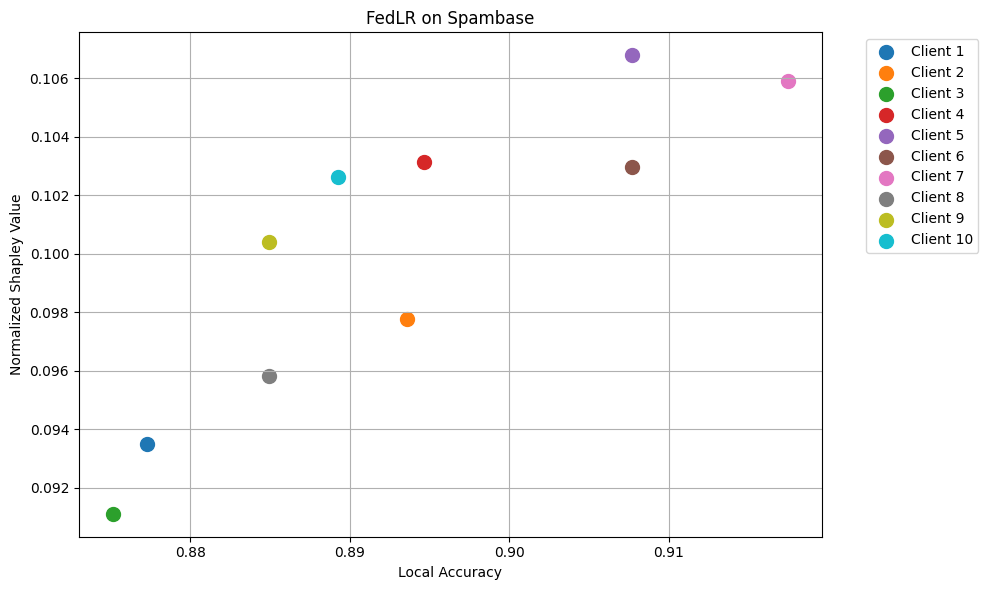

In [45]:
result = compute_and_visualize_shapley_values(
    df_results, 
    client_local_accuracies={i: client_global_accuracies[i] for i in range(n_clients)}, 
    n_clients=10,  
    plot=True,  
    model_name="FedLR on Spambase",  
    print_df=True 
)


#### Evaluating Grand coalition as a Nash Eq For Spambase in different Max_iter Without LQC

In [46]:
random_seed= 42
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [47]:
n_trials = 50
n_clients = 10
base_random_seed = 42
max_iters = [10, 100]
approach = 'fedlr'


# Prepare saving directory
save_dir = "/Users/abbaszal/Documents/Thesis_Project_Spambase/results/Spambase_without_LQC/evaluate_grand_combination_without_LQC"
os.makedirs(save_dir, exist_ok=True)

all_details = []

for max_iter in max_iters:
    print(f"\nRunning experiment for max_iter = {max_iter}")
    nash_counts = Counter()
    details_for_this_param = []
    client_accuracy_details = []

    for trial in range(n_trials):

        # Set seed
        rand_component = random.randint(0, 500)
        trial_seed = base_random_seed + trial + int(1000 * max_iter) + 2 * rand_component

        # Partition client data
        partitions = split_data_equal(X_train, y_train, n_clients=n_clients, shuffle=True , random_seed= trial_seed)

        # Train federated models
        client_models, client_global_acc = train_models_fedlr(
            partitions=partitions,
            random_seed=trial_seed,
            X_test=X_test,
            y_test=y_test,
            max_iter=max_iter
        )

        # Evaluate all coalitions
        df_results = evaluate_coalitions(
            client_models=client_models,
            client_global_accuracies=client_global_acc,
            n_clients=n_clients,
            aggregator_func=aggregate_lr_models,
            X_test=X_test,
            y_test=y_test,
            corrupt_client_indices=[],
            approach=approach
        )
        df_results['Trial'] = trial + 1
        df_results['Max Iter or Depth'] = max_iter


        df_nash = find_nash_equilibria_v2(df_results.reset_index())
        for coalition in df_nash['Combination']:
            nash_counts[coalition] += 1
        df_nash['Trial'] = trial + 1
        df_nash['Max Iter or Depth'] = max_iter
        details_for_this_param.append(df_nash)


        trial_acc = {
            'Trial': trial + 1,
            'Max Iter or Depth': max_iter,
        }
        for j in range(n_clients):
            col_name = f'Client {j+1} Accuracy'
            trial_acc[col_name] = client_global_acc[j] if client_global_acc[j] is not None else np.nan
        client_accuracy_details.append(trial_acc)

    # Save Nash count summary
    df_nash_counts = pd.DataFrame(nash_counts.items(), columns=['Nash Equilibrium', 'Occurrences'])
    df_nash_counts['Max Iter or Depth'] = max_iter
    filename_counts = os.path.join(save_dir, f"Nash_Equilibrium_Counts_{approach}_maxiter_{max_iter}.csv")
    df_nash_counts.to_csv(filename_counts, index=False)

    # Merge trial-wise Nash + client accuracy details
    df_details = pd.concat(details_for_this_param, ignore_index=True)
    df_client_accuracy = pd.DataFrame(client_accuracy_details)
    df_combined = df_details.merge(
        df_client_accuracy,
        on=['Trial', 'Max Iter or Depth'],
        how='left'
    )
    all_details.append(df_combined)




final_details_df = pd.concat(all_details, ignore_index=True)
details_path = os.path.join(save_dir, f"Nash_Equilibrium_Details_{approach}.csv")
final_details_df.to_csv(details_path, index=False)



Running experiment for max_iter = 10

Running experiment for max_iter = 100
